In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats

In [2]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "3" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

In [3]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)

br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [4]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    


ep=311
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
ncluster=8
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

In [5]:
subclusternumbers=[4,6,8,6,6,6,6,4]
clusterRes_sub=np.zeros(clusterRes.size)-1
for i in np.unique(clusterRes):
    subcluster=subclusternumbers[i]
    subclustersavedir=os.path.join(clustersavedir,savenamecluster+'_subcluster'+str(i))

    savenameclustersub='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
    with open(os.path.join(subclustersavedir,savenameclustersub), 'rb') as output:
        subclusterRes=pickle.load(output)
        
    clusterRes_sub[clusterRes==i]=subclusterRes

print(np.sum(clusterRes_sub==-1))

0


In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [7]:
#load latent
datadir='/media/xinyi/dcis2idc/data'
# with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
#     allImg=pickle.load(input)
    
#VAE settings
seed=3
epochs=10000
saveFreq=2000
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=8000
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*3*3
fc_dim2=6000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

dropout=0.01
kl_weight=0.0000001
model_str='cnn_vae'

name='exp0'
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name

# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
# loss_match=torch.nn.MSELoss()
# # Create model
# if model_str=='cnn_vae':
#     modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     loss_kl=optimizer.optimizer_kl
#     loss_x=torch.nn.MSELoss()
# if model_str=='cnn_vae_sharded':
#     modelcnn = modelsCNN.CNN_VAE_sharded(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     loss_kl=optimizer.optimizer_kl
#     loss_x=torch.nn.MSELoss()
#     use_cuda=False

# if model_str=='cnn_vae_alexnet':
#     modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
#     loss_kl=optimizer.optimizer_kl
#     loss_x=torch.nn.MSELoss(reduction='sum')

    
# modelcnn.cuda()       
# optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

ep=311

#compute latent

# use_cuda=True
# modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
# latent=np.zeros((allImg.shape[0],fc_dim2))
# with torch.no_grad():
#     modelcnn.cuda()
#     modelcnn.eval()
#     nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
#     for i in range(nplotBatches):
#         plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
#         if use_cuda:
#             plotInput=plotInput.cuda().float()
#         recon,z, mu, logvar = modelcnn(plotInput)
#         latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=mu.cpu().detach().numpy()

with open(os.path.join(datadir,'processed','latent311'), 'rb') as input:
    latent=pickle.load(input)

In [8]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=6000
model_str='fc3'

kernel_size=4
stride=2
padding=1

fc_dim1=1024
fc_dim2=1024
fc_dim3=1024


dropout=0.01
kl_weight=0.0000001

name='exp0_pathologyClf_latent_subclusters_'+savenamecluster+'fcl3'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)


In [15]:
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainIdx.shape[0]/batchsize))):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        
#         trainInput=trainInputnp[trainIdx]
#         labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(stats_sub[trainIdx_i]).cuda().float()
            labels=torch.tensor(labels_sub[trainIdx_i]).cuda().long()
        optimizer.zero_grad()

        pred = model(trainInput)
#         print(trainInput)
#         print(pred)


        loss=lossCE(pred,labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/int(np.ceil(trainIdx.shape[0]/batchsize))
    
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            if use_cuda:
                valInput=torch.tensor(stats_sub[valIdx_i]).cuda().float()
                labels=torch.tensor(labels_sub[valIdx_i]).cuda().long()
                
            pred= model(valInput)

            loss_val=lossCE(pred,labels).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    if epoch%50==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all

In [10]:
modelcnn.cpu()
modelcnn=None
gc.collect()

190

In [11]:
torch.cuda.empty_cache()

Epoch: 0000 loss_train: 2.3987 loss_val: 2.3920
Epoch: 0050 loss_train: 2.1228 loss_val: 2.2891
Epoch: 0100 loss_train: 1.8331 loss_val: 2.5264
Epoch: 0150 loss_train: 1.5307 loss_val: 3.0077
Epoch: 0200 loss_train: 1.3041 loss_val: 3.5223
Epoch: 0250 loss_train: 1.1394 loss_val: 4.0012
Epoch: 0300 loss_train: 1.0308 loss_val: 4.4078
Epoch: 0350 loss_train: 0.8659 loss_val: 4.8907
Epoch: 0400 loss_train: 0.7928 loss_val: 4.9626
Epoch: 0450 loss_train: 0.6788 loss_val: 5.4472
Epoch: 0500 loss_train: 0.6230 loss_val: 5.7112
Epoch: 0550 loss_train: 0.5712 loss_val: 5.6884
Epoch: 0600 loss_train: 0.5088 loss_val: 5.9210
Epoch: 0650 loss_train: 0.4770 loss_val: 6.1941
Epoch: 0700 loss_train: 0.4426 loss_val: 6.4045
Epoch: 0750 loss_train: 0.4136 loss_val: 6.5229
Epoch: 0800 loss_train: 0.3637 loss_val: 6.6223
Epoch: 0850 loss_train: 0.3535 loss_val: 6.6654
Epoch: 0900 loss_train: 0.3093 loss_val: 6.7810
Epoch: 0950 loss_train: 0.2993 loss_val: 6.9082
Epoch: 1000 loss_train: 0.2940 loss_val:

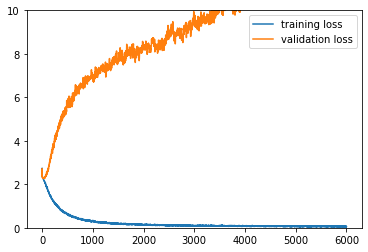

Epoch: 0000 loss_train: 2.3979 loss_val: 2.3992
Epoch: 0050 loss_train: 2.1909 loss_val: 2.1911
Epoch: 0100 loss_train: 1.9805 loss_val: 2.2363
Epoch: 0150 loss_train: 1.7030 loss_val: 2.4615
Epoch: 0200 loss_train: 1.4342 loss_val: 2.7423
Epoch: 0250 loss_train: 1.1795 loss_val: 3.1084
Epoch: 0300 loss_train: 1.0330 loss_val: 3.5100
Epoch: 0350 loss_train: 0.8836 loss_val: 3.7725
Epoch: 0400 loss_train: 0.7831 loss_val: 4.0220
Epoch: 0450 loss_train: 0.7034 loss_val: 4.3117
Epoch: 0500 loss_train: 0.6690 loss_val: 4.5269
Epoch: 0550 loss_train: 0.5572 loss_val: 4.6166
Epoch: 0600 loss_train: 0.5827 loss_val: 4.7879
Epoch: 0650 loss_train: 0.5036 loss_val: 4.7899
Epoch: 0700 loss_train: 0.4775 loss_val: 5.1106
Epoch: 0750 loss_train: 0.4150 loss_val: 5.1505
Epoch: 0800 loss_train: 0.4054 loss_val: 5.1793
Epoch: 0850 loss_train: 0.3864 loss_val: 5.4181
Epoch: 0900 loss_train: 0.3632 loss_val: 5.3952
Epoch: 0950 loss_train: 0.3419 loss_val: 5.6756
Epoch: 1000 loss_train: 0.3104 loss_val:

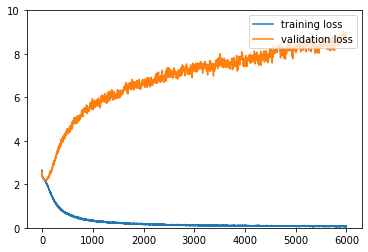

Epoch: 0000 loss_train: 2.3989 loss_val: 2.4073
Epoch: 0050 loss_train: 2.1754 loss_val: 2.3670
Epoch: 0100 loss_train: 1.8993 loss_val: 2.4898
Epoch: 0150 loss_train: 1.5664 loss_val: 2.9291
Epoch: 0200 loss_train: 1.3140 loss_val: 3.3816
Epoch: 0250 loss_train: 1.0917 loss_val: 3.6930
Epoch: 0300 loss_train: 0.9391 loss_val: 3.9779
Epoch: 0350 loss_train: 0.8209 loss_val: 4.3381
Epoch: 0400 loss_train: 0.7269 loss_val: 4.5703
Epoch: 0450 loss_train: 0.6073 loss_val: 4.8471
Epoch: 0500 loss_train: 0.5736 loss_val: 4.9073
Epoch: 0550 loss_train: 0.4951 loss_val: 5.0160
Epoch: 0600 loss_train: 0.4945 loss_val: 5.2644
Epoch: 0650 loss_train: 0.4337 loss_val: 5.3257
Epoch: 0700 loss_train: 0.4190 loss_val: 5.5043
Epoch: 0750 loss_train: 0.3694 loss_val: 5.7303
Epoch: 0800 loss_train: 0.3713 loss_val: 5.6886
Epoch: 0850 loss_train: 0.3585 loss_val: 5.8078
Epoch: 0900 loss_train: 0.3152 loss_val: 5.8932
Epoch: 0950 loss_train: 0.2961 loss_val: 5.8964
Epoch: 1000 loss_train: 0.3072 loss_val:

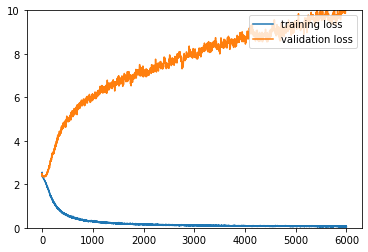

Epoch: 0000 loss_train: 2.4175 loss_val: 2.5365
Epoch: 0050 loss_train: 1.9867 loss_val: 2.3576
Epoch: 0100 loss_train: 1.6506 loss_val: 2.4174
Epoch: 0150 loss_train: 1.3775 loss_val: 2.5039
Epoch: 0200 loss_train: 1.2026 loss_val: 2.5439
Epoch: 0250 loss_train: 1.0540 loss_val: 2.6491
Epoch: 0300 loss_train: 0.9525 loss_val: 2.7434
Epoch: 0350 loss_train: 0.8443 loss_val: 2.9146
Epoch: 0400 loss_train: 0.7883 loss_val: 3.0143
Epoch: 0450 loss_train: 0.7071 loss_val: 3.2086
Epoch: 0500 loss_train: 0.6351 loss_val: 3.3248
Epoch: 0550 loss_train: 0.5759 loss_val: 3.4769
Epoch: 0600 loss_train: 0.5427 loss_val: 3.6090
Epoch: 0650 loss_train: 0.5021 loss_val: 3.6872
Epoch: 0700 loss_train: 0.4661 loss_val: 3.8841
Epoch: 0750 loss_train: 0.4527 loss_val: 3.9765
Epoch: 0800 loss_train: 0.4138 loss_val: 4.2344
Epoch: 0850 loss_train: 0.3889 loss_val: 4.3278
Epoch: 0900 loss_train: 0.3559 loss_val: 4.4772
Epoch: 0950 loss_train: 0.3301 loss_val: 4.6377
Epoch: 1000 loss_train: 0.3184 loss_val:

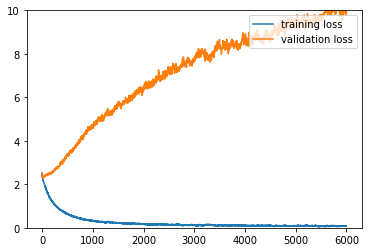

Epoch: 0000 loss_train: 2.4083 loss_val: 2.5036
Epoch: 0050 loss_train: 2.3027 loss_val: 2.3512
Epoch: 0100 loss_train: 2.1995 loss_val: 2.3726
Epoch: 0150 loss_train: 2.0706 loss_val: 2.4229
Epoch: 0200 loss_train: 1.9539 loss_val: 2.4997
Epoch: 0250 loss_train: 1.8112 loss_val: 2.5533
Epoch: 0300 loss_train: 1.6705 loss_val: 2.5852
Epoch: 0350 loss_train: 1.5374 loss_val: 2.7274
Epoch: 0400 loss_train: 1.3965 loss_val: 2.8033
Epoch: 0450 loss_train: 1.2874 loss_val: 3.0016
Epoch: 0500 loss_train: 1.1769 loss_val: 3.0864
Epoch: 0550 loss_train: 1.0742 loss_val: 3.2525
Epoch: 0600 loss_train: 0.9575 loss_val: 3.4644
Epoch: 0650 loss_train: 0.8785 loss_val: 3.5886
Epoch: 0700 loss_train: 0.7838 loss_val: 3.7552
Epoch: 0750 loss_train: 0.7356 loss_val: 3.8918
Epoch: 0800 loss_train: 0.6771 loss_val: 4.0244
Epoch: 0850 loss_train: 0.6469 loss_val: 4.1964
Epoch: 0900 loss_train: 0.5849 loss_val: 4.3839
Epoch: 0950 loss_train: 0.5427 loss_val: 4.4476
Epoch: 1000 loss_train: 0.4826 loss_val:

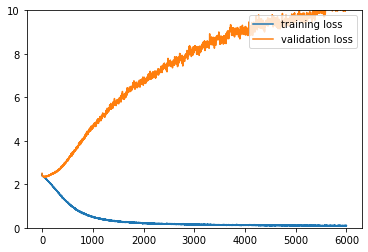

Epoch: 0000 loss_train: 2.4160 loss_val: 2.4727
Epoch: 0050 loss_train: 2.2490 loss_val: 2.3415
Epoch: 0100 loss_train: 2.1845 loss_val: 2.3695
Epoch: 0150 loss_train: 2.1202 loss_val: 2.3922
Epoch: 0200 loss_train: 2.0155 loss_val: 2.4191
Epoch: 0250 loss_train: 1.9662 loss_val: 2.4529
Epoch: 0300 loss_train: 1.9010 loss_val: 2.5053
Epoch: 0350 loss_train: 1.8286 loss_val: 2.5385
Epoch: 0400 loss_train: 1.7605 loss_val: 2.6033
Epoch: 0450 loss_train: 1.6778 loss_val: 2.6195
Epoch: 0500 loss_train: 1.5890 loss_val: 2.6773
Epoch: 0550 loss_train: 1.5065 loss_val: 2.7920
Epoch: 0600 loss_train: 1.4009 loss_val: 2.8488
Epoch: 0650 loss_train: 1.3744 loss_val: 2.9487
Epoch: 0700 loss_train: 1.2961 loss_val: 3.0456
Epoch: 0750 loss_train: 1.2257 loss_val: 3.0966
Epoch: 0800 loss_train: 1.1626 loss_val: 3.2372
Epoch: 0850 loss_train: 1.0858 loss_val: 3.3543
Epoch: 0900 loss_train: 1.0085 loss_val: 3.5475
Epoch: 0950 loss_train: 0.9514 loss_val: 3.6914
Epoch: 1000 loss_train: 0.8658 loss_val:

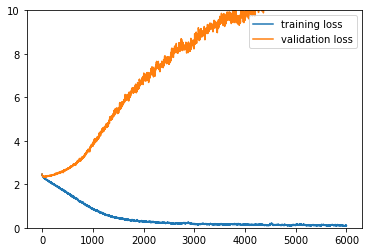

Epoch: 0000 loss_train: 2.4142 loss_val: 2.5018
Epoch: 0050 loss_train: 2.3244 loss_val: 2.3717
Epoch: 0100 loss_train: 2.2676 loss_val: 2.4044
Epoch: 0150 loss_train: 2.2058 loss_val: 2.4490
Epoch: 0200 loss_train: 2.1259 loss_val: 2.5140
Epoch: 0250 loss_train: 2.0256 loss_val: 2.6587
Epoch: 0300 loss_train: 1.9391 loss_val: 2.7343
Epoch: 0350 loss_train: 1.8196 loss_val: 2.8754
Epoch: 0400 loss_train: 1.7132 loss_val: 3.0456
Epoch: 0450 loss_train: 1.6058 loss_val: 3.1913
Epoch: 0500 loss_train: 1.4807 loss_val: 3.3691
Epoch: 0550 loss_train: 1.3926 loss_val: 3.5829
Epoch: 0600 loss_train: 1.3121 loss_val: 3.8298
Epoch: 0650 loss_train: 1.2217 loss_val: 3.9822
Epoch: 0700 loss_train: 1.1220 loss_val: 4.3132
Epoch: 0750 loss_train: 1.0411 loss_val: 4.4510
Epoch: 0800 loss_train: 0.9641 loss_val: 4.7098
Epoch: 0850 loss_train: 0.9134 loss_val: 4.9697
Epoch: 0900 loss_train: 0.8207 loss_val: 5.1031
Epoch: 0950 loss_train: 0.7720 loss_val: 5.2855
Epoch: 1000 loss_train: 0.7283 loss_val:

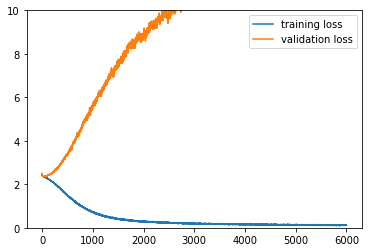

Epoch: 0000 loss_train: 2.3981 loss_val: 2.4031
Epoch: 0050 loss_train: 2.3357 loss_val: 2.3555
Epoch: 0100 loss_train: 2.2679 loss_val: 2.3992
Epoch: 0150 loss_train: 2.2207 loss_val: 2.4267
Epoch: 0200 loss_train: 2.1180 loss_val: 2.5024
Epoch: 0250 loss_train: 2.0625 loss_val: 2.6015
Epoch: 0300 loss_train: 1.9496 loss_val: 2.7101
Epoch: 0350 loss_train: 1.8625 loss_val: 2.8190
Epoch: 0400 loss_train: 1.8022 loss_val: 2.9025
Epoch: 0450 loss_train: 1.7261 loss_val: 3.0213
Epoch: 0500 loss_train: 1.6334 loss_val: 3.2054
Epoch: 0550 loss_train: 1.5577 loss_val: 3.3565
Epoch: 0600 loss_train: 1.4760 loss_val: 3.4927
Epoch: 0650 loss_train: 1.4239 loss_val: 3.6494
Epoch: 0700 loss_train: 1.3026 loss_val: 3.8248
Epoch: 0750 loss_train: 1.2440 loss_val: 4.0213
Epoch: 0800 loss_train: 1.1879 loss_val: 4.1033
Epoch: 0850 loss_train: 1.1307 loss_val: 4.3027
Epoch: 0900 loss_train: 1.0487 loss_val: 4.5204
Epoch: 0950 loss_train: 0.9905 loss_val: 4.4345
Epoch: 1000 loss_train: 0.9395 loss_val:

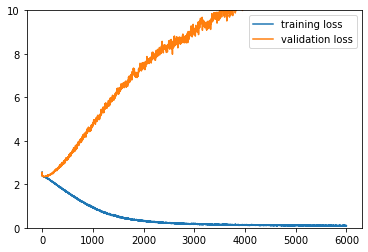

Epoch: 0000 loss_train: 2.4220 loss_val: 2.4446
Epoch: 0050 loss_train: 2.2566 loss_val: 2.4272
Epoch: 0100 loss_train: 2.0213 loss_val: 2.5097
Epoch: 0150 loss_train: 1.8267 loss_val: 2.5521
Epoch: 0200 loss_train: 1.6724 loss_val: 2.5531
Epoch: 0250 loss_train: 1.5226 loss_val: 2.5566
Epoch: 0300 loss_train: 1.4424 loss_val: 2.6065
Epoch: 0350 loss_train: 1.3278 loss_val: 2.6527
Epoch: 0400 loss_train: 1.2647 loss_val: 2.7202
Epoch: 0450 loss_train: 1.2096 loss_val: 2.7659
Epoch: 0500 loss_train: 1.1223 loss_val: 2.8352
Epoch: 0550 loss_train: 1.0222 loss_val: 2.9920
Epoch: 0600 loss_train: 0.9483 loss_val: 3.0289
Epoch: 0650 loss_train: 0.9115 loss_val: 3.1280
Epoch: 0700 loss_train: 0.8167 loss_val: 3.2030
Epoch: 0750 loss_train: 0.7733 loss_val: 3.3566
Epoch: 0800 loss_train: 0.7106 loss_val: 3.5303
Epoch: 0850 loss_train: 0.6327 loss_val: 3.7164
Epoch: 0900 loss_train: 0.5795 loss_val: 3.9046
Epoch: 0950 loss_train: 0.5076 loss_val: 4.0234
Epoch: 1000 loss_train: 0.4987 loss_val:

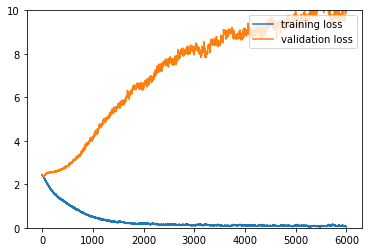

Epoch: 0000 loss_train: 2.3982 loss_val: 2.4014
Epoch: 0050 loss_train: 2.3248 loss_val: 2.3813
Epoch: 0100 loss_train: 2.2471 loss_val: 2.4395
Epoch: 0150 loss_train: 2.1302 loss_val: 2.5727
Epoch: 0200 loss_train: 1.9890 loss_val: 2.7187
Epoch: 0250 loss_train: 1.8825 loss_val: 2.7931
Epoch: 0300 loss_train: 1.7678 loss_val: 2.9818
Epoch: 0350 loss_train: 1.6412 loss_val: 3.2119
Epoch: 0400 loss_train: 1.5435 loss_val: 3.2667
Epoch: 0450 loss_train: 1.4549 loss_val: 3.4944
Epoch: 0500 loss_train: 1.3585 loss_val: 3.5752
Epoch: 0550 loss_train: 1.2714 loss_val: 3.7752
Epoch: 0600 loss_train: 1.1991 loss_val: 3.9764
Epoch: 0650 loss_train: 1.1258 loss_val: 4.0941
Epoch: 0700 loss_train: 1.0369 loss_val: 4.2194
Epoch: 0750 loss_train: 0.9951 loss_val: 4.2698
Epoch: 0800 loss_train: 0.9568 loss_val: 4.5104
Epoch: 0850 loss_train: 0.8479 loss_val: 4.6378
Epoch: 0900 loss_train: 0.8408 loss_val: 4.6553
Epoch: 0950 loss_train: 0.7617 loss_val: 4.8622
Epoch: 1000 loss_train: 0.7275 loss_val:

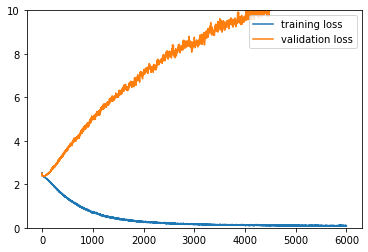

Epoch: 0000 loss_train: 2.3983 loss_val: 2.4041
Epoch: 0050 loss_train: 2.1583 loss_val: 2.2269
Epoch: 0100 loss_train: 1.9450 loss_val: 2.2682
Epoch: 0150 loss_train: 1.7372 loss_val: 2.4612
Epoch: 0200 loss_train: 1.4624 loss_val: 2.5883
Epoch: 0250 loss_train: 1.2771 loss_val: 2.8511
Epoch: 0300 loss_train: 1.0370 loss_val: 3.1595
Epoch: 0350 loss_train: 0.9236 loss_val: 3.5101
Epoch: 0400 loss_train: 0.8122 loss_val: 3.6830
Epoch: 0450 loss_train: 0.7230 loss_val: 4.0088
Epoch: 0500 loss_train: 0.6589 loss_val: 4.0918
Epoch: 0550 loss_train: 0.5999 loss_val: 4.1302
Epoch: 0600 loss_train: 0.5313 loss_val: 4.2420
Epoch: 0650 loss_train: 0.4941 loss_val: 4.5217
Epoch: 0700 loss_train: 0.4620 loss_val: 4.8250
Epoch: 0750 loss_train: 0.4507 loss_val: 4.7832
Epoch: 0800 loss_train: 0.4324 loss_val: 4.7858
Epoch: 0850 loss_train: 0.3815 loss_val: 4.8412
Epoch: 0900 loss_train: 0.3826 loss_val: 4.9884
Epoch: 0950 loss_train: 0.3404 loss_val: 5.1004
Epoch: 1000 loss_train: 0.3143 loss_val:

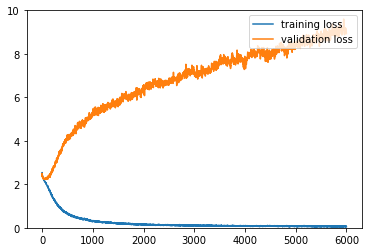

Epoch: 0000 loss_train: 2.3984 loss_val: 2.4042
Epoch: 0050 loss_train: 2.2362 loss_val: 2.3197
Epoch: 0100 loss_train: 2.0151 loss_val: 2.4969
Epoch: 0150 loss_train: 1.7220 loss_val: 2.6540
Epoch: 0200 loss_train: 1.5053 loss_val: 2.8694
Epoch: 0250 loss_train: 1.2981 loss_val: 3.0705
Epoch: 0300 loss_train: 1.1207 loss_val: 3.3940
Epoch: 0350 loss_train: 0.9925 loss_val: 3.5444
Epoch: 0400 loss_train: 0.8679 loss_val: 3.7732
Epoch: 0450 loss_train: 0.7951 loss_val: 4.0630
Epoch: 0500 loss_train: 0.6848 loss_val: 4.2056
Epoch: 0550 loss_train: 0.6454 loss_val: 4.4934
Epoch: 0600 loss_train: 0.5531 loss_val: 4.6076
Epoch: 0650 loss_train: 0.5385 loss_val: 4.8030
Epoch: 0700 loss_train: 0.4995 loss_val: 4.7177
Epoch: 0750 loss_train: 0.4790 loss_val: 4.9228
Epoch: 0800 loss_train: 0.4008 loss_val: 5.1993
Epoch: 0850 loss_train: 0.4490 loss_val: 5.1110
Epoch: 0900 loss_train: 0.3524 loss_val: 5.4356
Epoch: 0950 loss_train: 0.3764 loss_val: 5.3414
Epoch: 1000 loss_train: 0.3465 loss_val:

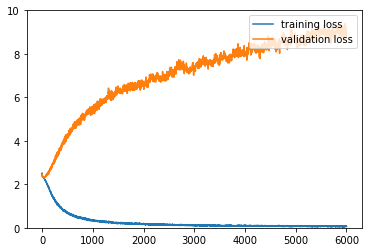

Epoch: 0000 loss_train: 2.3984 loss_val: 2.3903
Epoch: 0050 loss_train: 2.1644 loss_val: 2.2490
Epoch: 0100 loss_train: 1.9304 loss_val: 2.3828
Epoch: 0150 loss_train: 1.6020 loss_val: 2.6981
Epoch: 0200 loss_train: 1.3029 loss_val: 3.0032
Epoch: 0250 loss_train: 1.0767 loss_val: 3.4041
Epoch: 0300 loss_train: 0.9214 loss_val: 3.6944
Epoch: 0350 loss_train: 0.7473 loss_val: 3.9901
Epoch: 0400 loss_train: 0.6915 loss_val: 4.2011
Epoch: 0450 loss_train: 0.5852 loss_val: 4.4224
Epoch: 0500 loss_train: 0.4995 loss_val: 4.4903
Epoch: 0550 loss_train: 0.4857 loss_val: 4.7012
Epoch: 0600 loss_train: 0.4556 loss_val: 4.7234
Epoch: 0650 loss_train: 0.4187 loss_val: 4.7788
Epoch: 0700 loss_train: 0.3849 loss_val: 4.8988
Epoch: 0750 loss_train: 0.3587 loss_val: 4.9846
Epoch: 0800 loss_train: 0.3273 loss_val: 5.2916
Epoch: 0850 loss_train: 0.3018 loss_val: 5.3928
Epoch: 0900 loss_train: 0.3103 loss_val: 5.4936
Epoch: 0950 loss_train: 0.2455 loss_val: 5.4616
Epoch: 1000 loss_train: 0.2649 loss_val:

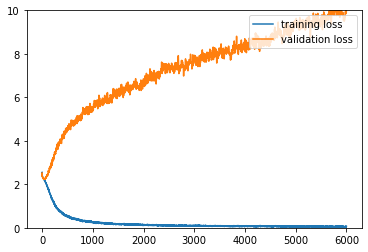

Epoch: 0000 loss_train: 2.3986 loss_val: 2.4160
Epoch: 0050 loss_train: 2.2030 loss_val: 2.2739
Epoch: 0100 loss_train: 2.0630 loss_val: 2.3258
Epoch: 0150 loss_train: 1.8524 loss_val: 2.4869
Epoch: 0200 loss_train: 1.6647 loss_val: 2.6229
Epoch: 0250 loss_train: 1.4747 loss_val: 2.7023
Epoch: 0300 loss_train: 1.3056 loss_val: 2.9814
Epoch: 0350 loss_train: 1.1653 loss_val: 3.1816
Epoch: 0400 loss_train: 1.0505 loss_val: 3.3208
Epoch: 0450 loss_train: 0.9578 loss_val: 3.3832
Epoch: 0500 loss_train: 0.8537 loss_val: 3.5904
Epoch: 0550 loss_train: 0.7749 loss_val: 3.7483
Epoch: 0600 loss_train: 0.7227 loss_val: 3.8482
Epoch: 0650 loss_train: 0.6598 loss_val: 4.0430
Epoch: 0700 loss_train: 0.6347 loss_val: 4.1255
Epoch: 0750 loss_train: 0.5896 loss_val: 4.2308
Epoch: 0800 loss_train: 0.5521 loss_val: 4.4220
Epoch: 0850 loss_train: 0.5267 loss_val: 4.4144
Epoch: 0900 loss_train: 0.4818 loss_val: 4.5198
Epoch: 0950 loss_train: 0.4504 loss_val: 4.6770
Epoch: 1000 loss_train: 0.4174 loss_val:

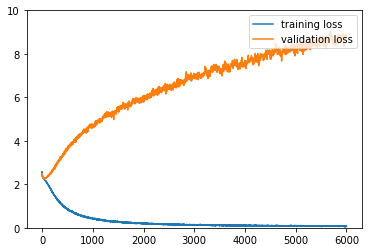

Epoch: 0000 loss_train: 2.3985 loss_val: 2.4004
Epoch: 0050 loss_train: 2.1640 loss_val: 2.3136
Epoch: 0100 loss_train: 1.8678 loss_val: 2.4746
Epoch: 0150 loss_train: 1.5881 loss_val: 2.6922
Epoch: 0200 loss_train: 1.3202 loss_val: 3.0702
Epoch: 0250 loss_train: 1.1476 loss_val: 3.3608
Epoch: 0300 loss_train: 0.9612 loss_val: 3.5798
Epoch: 0350 loss_train: 0.8563 loss_val: 3.9744
Epoch: 0400 loss_train: 0.7368 loss_val: 4.2309
Epoch: 0450 loss_train: 0.6530 loss_val: 4.3085
Epoch: 0500 loss_train: 0.6153 loss_val: 4.5319
Epoch: 0550 loss_train: 0.5600 loss_val: 4.7506
Epoch: 0600 loss_train: 0.4698 loss_val: 4.7722
Epoch: 0650 loss_train: 0.4740 loss_val: 4.8982
Epoch: 0700 loss_train: 0.4314 loss_val: 5.0103
Epoch: 0750 loss_train: 0.3643 loss_val: 5.0035
Epoch: 0800 loss_train: 0.3593 loss_val: 5.5396
Epoch: 0850 loss_train: 0.3261 loss_val: 5.4851
Epoch: 0900 loss_train: 0.3265 loss_val: 5.5185
Epoch: 0950 loss_train: 0.2736 loss_val: 5.6989
Epoch: 1000 loss_train: 0.2657 loss_val:

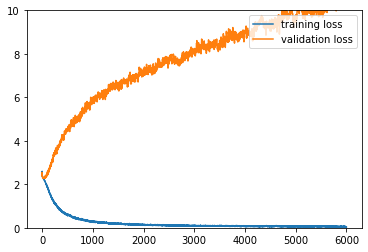

Epoch: 0000 loss_train: 2.3987 loss_val: 2.3937
Epoch: 0050 loss_train: 2.1682 loss_val: 2.3735
Epoch: 0100 loss_train: 1.8180 loss_val: 2.6799
Epoch: 0150 loss_train: 1.4455 loss_val: 3.1441
Epoch: 0200 loss_train: 1.1288 loss_val: 3.8438
Epoch: 0250 loss_train: 0.8810 loss_val: 4.4411
Epoch: 0300 loss_train: 0.7198 loss_val: 4.8668
Epoch: 0350 loss_train: 0.6770 loss_val: 5.2445
Epoch: 0400 loss_train: 0.5694 loss_val: 5.5429
Epoch: 0450 loss_train: 0.4700 loss_val: 5.7673
Epoch: 0500 loss_train: 0.4540 loss_val: 5.9414
Epoch: 0550 loss_train: 0.3864 loss_val: 6.2783
Epoch: 0600 loss_train: 0.3760 loss_val: 6.4843
Epoch: 0650 loss_train: 0.3232 loss_val: 6.5492
Epoch: 0700 loss_train: 0.2897 loss_val: 6.7208
Epoch: 0750 loss_train: 0.2970 loss_val: 6.5559
Epoch: 0800 loss_train: 0.2739 loss_val: 6.8958
Epoch: 0850 loss_train: 0.2981 loss_val: 6.9239
Epoch: 0900 loss_train: 0.2272 loss_val: 7.1850
Epoch: 0950 loss_train: 0.2479 loss_val: 7.0139
Epoch: 1000 loss_train: 0.2451 loss_val:

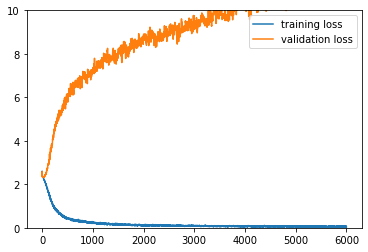

Epoch: 0000 loss_train: 2.3979 loss_val: 2.4061
Epoch: 0050 loss_train: 2.2107 loss_val: 2.3391
Epoch: 0100 loss_train: 1.9766 loss_val: 2.4182
Epoch: 0150 loss_train: 1.6914 loss_val: 2.7634
Epoch: 0200 loss_train: 1.4198 loss_val: 3.0920
Epoch: 0250 loss_train: 1.2281 loss_val: 3.4433
Epoch: 0300 loss_train: 1.0404 loss_val: 3.7706
Epoch: 0350 loss_train: 0.9052 loss_val: 4.0942
Epoch: 0400 loss_train: 0.7953 loss_val: 4.4134
Epoch: 0450 loss_train: 0.7111 loss_val: 4.5834
Epoch: 0500 loss_train: 0.6254 loss_val: 4.8181
Epoch: 0550 loss_train: 0.5562 loss_val: 4.9900
Epoch: 0600 loss_train: 0.5374 loss_val: 5.3601
Epoch: 0650 loss_train: 0.4770 loss_val: 5.4070
Epoch: 0700 loss_train: 0.4347 loss_val: 5.5596
Epoch: 0750 loss_train: 0.4207 loss_val: 5.6598
Epoch: 0800 loss_train: 0.3622 loss_val: 5.6580
Epoch: 0850 loss_train: 0.3721 loss_val: 5.5756
Epoch: 0900 loss_train: 0.3308 loss_val: 5.7785
Epoch: 0950 loss_train: 0.3226 loss_val: 5.7836
Epoch: 1000 loss_train: 0.3228 loss_val:

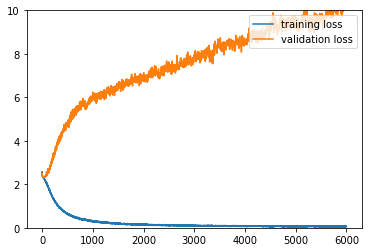

Epoch: 0000 loss_train: 2.3982 loss_val: 2.4040
Epoch: 0050 loss_train: 2.1748 loss_val: 2.2781
Epoch: 0100 loss_train: 1.9232 loss_val: 2.4061
Epoch: 0150 loss_train: 1.6069 loss_val: 2.6438
Epoch: 0200 loss_train: 1.3245 loss_val: 2.7908
Epoch: 0250 loss_train: 1.1078 loss_val: 3.0870
Epoch: 0300 loss_train: 0.9339 loss_val: 3.3188
Epoch: 0350 loss_train: 0.7550 loss_val: 3.6249
Epoch: 0400 loss_train: 0.6774 loss_val: 3.7785
Epoch: 0450 loss_train: 0.6048 loss_val: 4.0020
Epoch: 0500 loss_train: 0.5435 loss_val: 4.1175
Epoch: 0550 loss_train: 0.4777 loss_val: 4.3408
Epoch: 0600 loss_train: 0.4562 loss_val: 4.2730
Epoch: 0650 loss_train: 0.4357 loss_val: 4.6015
Epoch: 0700 loss_train: 0.3853 loss_val: 4.4941
Epoch: 0750 loss_train: 0.3654 loss_val: 4.8061
Epoch: 0800 loss_train: 0.3526 loss_val: 4.8382
Epoch: 0850 loss_train: 0.3402 loss_val: 4.9158
Epoch: 0900 loss_train: 0.3157 loss_val: 4.9855
Epoch: 0950 loss_train: 0.2892 loss_val: 5.1808
Epoch: 1000 loss_train: 0.2766 loss_val:

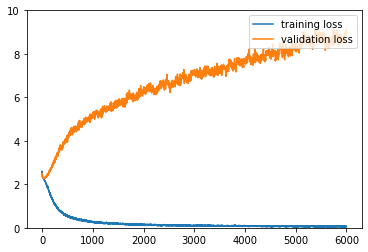

Epoch: 0000 loss_train: 2.3986 loss_val: 2.4096
Epoch: 0050 loss_train: 2.2893 loss_val: 2.3549
Epoch: 0100 loss_train: 2.1537 loss_val: 2.4305
Epoch: 0150 loss_train: 1.9746 loss_val: 2.5616
Epoch: 0200 loss_train: 1.8180 loss_val: 2.7263
Epoch: 0250 loss_train: 1.6503 loss_val: 2.9057
Epoch: 0300 loss_train: 1.5625 loss_val: 3.0842
Epoch: 0350 loss_train: 1.4273 loss_val: 3.2998
Epoch: 0400 loss_train: 1.3036 loss_val: 3.3936
Epoch: 0450 loss_train: 1.2337 loss_val: 3.7184
Epoch: 0500 loss_train: 1.1262 loss_val: 3.8231
Epoch: 0550 loss_train: 1.0468 loss_val: 4.1008
Epoch: 0600 loss_train: 0.9645 loss_val: 4.2796
Epoch: 0650 loss_train: 0.9231 loss_val: 4.4022
Epoch: 0700 loss_train: 0.8784 loss_val: 4.4283
Epoch: 0750 loss_train: 0.8405 loss_val: 4.4703
Epoch: 0800 loss_train: 0.7739 loss_val: 4.6584
Epoch: 0850 loss_train: 0.7502 loss_val: 4.7781
Epoch: 0900 loss_train: 0.6814 loss_val: 4.8463
Epoch: 0950 loss_train: 0.6474 loss_val: 4.9396
Epoch: 1000 loss_train: 0.6101 loss_val:

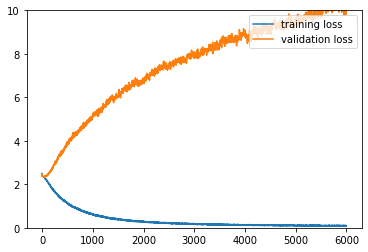

Epoch: 0000 loss_train: 2.4380 loss_val: 2.4414
Epoch: 0050 loss_train: 2.2213 loss_val: 2.2694
Epoch: 0100 loss_train: 2.0711 loss_val: 2.3377
Epoch: 0150 loss_train: 1.9079 loss_val: 2.4500
Epoch: 0200 loss_train: 1.7316 loss_val: 2.5879
Epoch: 0250 loss_train: 1.5737 loss_val: 2.7634
Epoch: 0300 loss_train: 1.4345 loss_val: 2.9138
Epoch: 0350 loss_train: 1.2993 loss_val: 3.1146
Epoch: 0400 loss_train: 1.1722 loss_val: 3.2538
Epoch: 0450 loss_train: 1.0686 loss_val: 3.3936
Epoch: 0500 loss_train: 0.9777 loss_val: 3.6400
Epoch: 0550 loss_train: 0.9057 loss_val: 3.7302
Epoch: 0600 loss_train: 0.8206 loss_val: 3.8944
Epoch: 0650 loss_train: 0.7465 loss_val: 4.0804
Epoch: 0700 loss_train: 0.6958 loss_val: 4.2390
Epoch: 0750 loss_train: 0.6263 loss_val: 4.3671
Epoch: 0800 loss_train: 0.5921 loss_val: 4.5411
Epoch: 0850 loss_train: 0.5694 loss_val: 4.7420
Epoch: 0900 loss_train: 0.5264 loss_val: 4.9136
Epoch: 0950 loss_train: 0.4914 loss_val: 5.0461
Epoch: 1000 loss_train: 0.4641 loss_val:

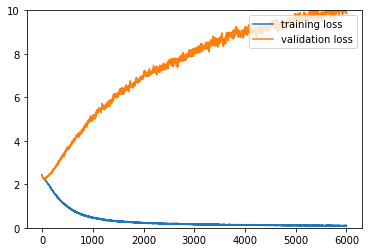

Epoch: 0000 loss_train: 2.3984 loss_val: 2.4052
Epoch: 0050 loss_train: 2.2359 loss_val: 2.3124
Epoch: 0100 loss_train: 2.0110 loss_val: 2.3478
Epoch: 0150 loss_train: 1.7362 loss_val: 2.4593
Epoch: 0200 loss_train: 1.4424 loss_val: 2.7934
Epoch: 0250 loss_train: 1.2324 loss_val: 3.0914
Epoch: 0300 loss_train: 1.0799 loss_val: 3.3764
Epoch: 0350 loss_train: 0.9614 loss_val: 3.6304
Epoch: 0400 loss_train: 0.8456 loss_val: 3.8786
Epoch: 0450 loss_train: 0.7542 loss_val: 4.0689
Epoch: 0500 loss_train: 0.6965 loss_val: 4.3817
Epoch: 0550 loss_train: 0.6122 loss_val: 4.7127
Epoch: 0600 loss_train: 0.5621 loss_val: 4.8764
Epoch: 0650 loss_train: 0.5106 loss_val: 4.7835
Epoch: 0700 loss_train: 0.5055 loss_val: 4.7469
Epoch: 0750 loss_train: 0.4401 loss_val: 4.9470
Epoch: 0800 loss_train: 0.4134 loss_val: 5.3773
Epoch: 0850 loss_train: 0.4338 loss_val: 5.3202
Epoch: 0900 loss_train: 0.3664 loss_val: 5.4352
Epoch: 0950 loss_train: 0.3719 loss_val: 5.5433
Epoch: 1000 loss_train: 0.3068 loss_val:

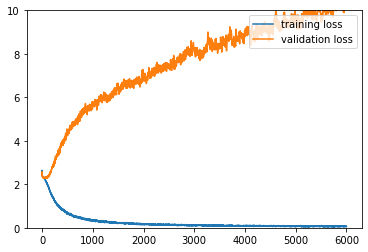

Epoch: 0000 loss_train: 2.3984 loss_val: 2.3873
Epoch: 0050 loss_train: 2.2483 loss_val: 2.3446
Epoch: 0100 loss_train: 2.0697 loss_val: 2.4857
Epoch: 0150 loss_train: 1.8177 loss_val: 2.6599
Epoch: 0200 loss_train: 1.6379 loss_val: 2.8178
Epoch: 0250 loss_train: 1.4074 loss_val: 3.0628
Epoch: 0300 loss_train: 1.2739 loss_val: 3.3222
Epoch: 0350 loss_train: 1.1259 loss_val: 3.5212
Epoch: 0400 loss_train: 1.0506 loss_val: 3.6060
Epoch: 0450 loss_train: 0.9201 loss_val: 3.9314
Epoch: 0500 loss_train: 0.8523 loss_val: 4.1199
Epoch: 0550 loss_train: 0.7963 loss_val: 4.1521
Epoch: 0600 loss_train: 0.7170 loss_val: 4.2019
Epoch: 0650 loss_train: 0.6929 loss_val: 4.4485
Epoch: 0700 loss_train: 0.6115 loss_val: 4.6351
Epoch: 0750 loss_train: 0.5715 loss_val: 4.7695
Epoch: 0800 loss_train: 0.5326 loss_val: 4.8556
Epoch: 0850 loss_train: 0.4992 loss_val: 5.0678
Epoch: 0900 loss_train: 0.4971 loss_val: 5.2458
Epoch: 0950 loss_train: 0.4598 loss_val: 5.0610
Epoch: 1000 loss_train: 0.4134 loss_val:

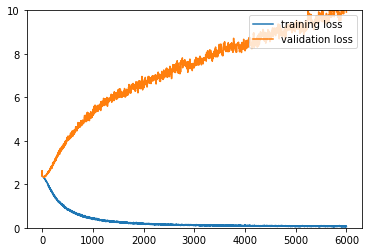

Epoch: 0000 loss_train: 2.4286 loss_val: 2.4384
Epoch: 0050 loss_train: 2.1827 loss_val: 2.4332
Epoch: 0100 loss_train: 1.9320 loss_val: 2.5105
Epoch: 0150 loss_train: 1.6755 loss_val: 2.4695
Epoch: 0200 loss_train: 1.5348 loss_val: 2.4701
Epoch: 0250 loss_train: 1.4440 loss_val: 2.4985
Epoch: 0300 loss_train: 1.3762 loss_val: 2.5404
Epoch: 0350 loss_train: 1.2459 loss_val: 2.5495
Epoch: 0400 loss_train: 1.1827 loss_val: 2.6003
Epoch: 0450 loss_train: 1.1202 loss_val: 2.6129
Epoch: 0500 loss_train: 1.0569 loss_val: 2.7122
Epoch: 0550 loss_train: 0.9868 loss_val: 2.7598
Epoch: 0600 loss_train: 0.8913 loss_val: 2.8757
Epoch: 0650 loss_train: 0.8592 loss_val: 2.9844
Epoch: 0700 loss_train: 0.8041 loss_val: 3.0011
Epoch: 0750 loss_train: 0.7537 loss_val: 3.2011
Epoch: 0800 loss_train: 0.6810 loss_val: 3.4300
Epoch: 0850 loss_train: 0.6470 loss_val: 3.5375
Epoch: 0900 loss_train: 0.5728 loss_val: 3.6790
Epoch: 0950 loss_train: 0.5581 loss_val: 3.8605
Epoch: 1000 loss_train: 0.5032 loss_val:

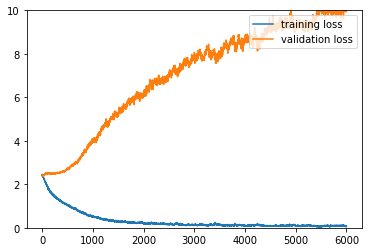

Epoch: 0000 loss_train: 2.3983 loss_val: 2.3984
Epoch: 0050 loss_train: 2.2429 loss_val: 2.3780
Epoch: 0100 loss_train: 2.0571 loss_val: 2.4630
Epoch: 0150 loss_train: 1.7804 loss_val: 2.6284
Epoch: 0200 loss_train: 1.5099 loss_val: 2.8581
Epoch: 0250 loss_train: 1.2969 loss_val: 3.1155
Epoch: 0300 loss_train: 1.1235 loss_val: 3.4281
Epoch: 0350 loss_train: 1.0156 loss_val: 3.6468
Epoch: 0400 loss_train: 0.8970 loss_val: 3.8441
Epoch: 0450 loss_train: 0.8378 loss_val: 4.0700
Epoch: 0500 loss_train: 0.7511 loss_val: 4.2892
Epoch: 0550 loss_train: 0.6645 loss_val: 4.5181
Epoch: 0600 loss_train: 0.6347 loss_val: 4.4828
Epoch: 0650 loss_train: 0.5426 loss_val: 4.7340
Epoch: 0700 loss_train: 0.5357 loss_val: 4.6500
Epoch: 0750 loss_train: 0.4717 loss_val: 4.7993
Epoch: 0800 loss_train: 0.4546 loss_val: 5.0498
Epoch: 0850 loss_train: 0.4305 loss_val: 5.1408
Epoch: 0900 loss_train: 0.3921 loss_val: 5.2114
Epoch: 0950 loss_train: 0.3736 loss_val: 5.2366
Epoch: 1000 loss_train: 0.3640 loss_val:

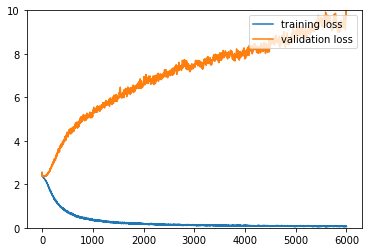

Epoch: 0000 loss_train: 2.3987 loss_val: 2.3930
Epoch: 0050 loss_train: 2.2016 loss_val: 2.3187
Epoch: 0100 loss_train: 1.9665 loss_val: 2.4490
Epoch: 0150 loss_train: 1.6855 loss_val: 2.6780
Epoch: 0200 loss_train: 1.4416 loss_val: 3.0042
Epoch: 0250 loss_train: 1.2341 loss_val: 3.3480
Epoch: 0300 loss_train: 1.0470 loss_val: 3.5490
Epoch: 0350 loss_train: 0.8924 loss_val: 3.9611
Epoch: 0400 loss_train: 0.8033 loss_val: 4.1891
Epoch: 0450 loss_train: 0.7116 loss_val: 4.4848
Epoch: 0500 loss_train: 0.6443 loss_val: 4.4771
Epoch: 0550 loss_train: 0.5778 loss_val: 4.7309
Epoch: 0600 loss_train: 0.5437 loss_val: 4.9146
Epoch: 0650 loss_train: 0.5057 loss_val: 5.0779
Epoch: 0700 loss_train: 0.4754 loss_val: 5.1178
Epoch: 0750 loss_train: 0.4281 loss_val: 5.3162
Epoch: 0800 loss_train: 0.3987 loss_val: 5.4765
Epoch: 0850 loss_train: 0.4054 loss_val: 5.5830
Epoch: 0900 loss_train: 0.3525 loss_val: 5.7736
Epoch: 0950 loss_train: 0.3378 loss_val: 5.9023
Epoch: 1000 loss_train: 0.2866 loss_val:

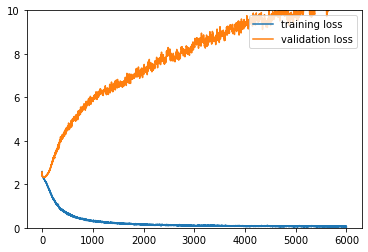

Epoch: 0000 loss_train: 2.3994 loss_val: 2.4044
Epoch: 0050 loss_train: 2.0722 loss_val: 2.2766
Epoch: 0100 loss_train: 1.6623 loss_val: 2.3577
Epoch: 0150 loss_train: 1.3137 loss_val: 2.5502
Epoch: 0200 loss_train: 1.0149 loss_val: 2.9959
Epoch: 0250 loss_train: 0.8114 loss_val: 3.3649
Epoch: 0300 loss_train: 0.6690 loss_val: 3.6862
Epoch: 0350 loss_train: 0.5888 loss_val: 3.8384
Epoch: 0400 loss_train: 0.5086 loss_val: 4.1888
Epoch: 0450 loss_train: 0.4004 loss_val: 4.3606
Epoch: 0500 loss_train: 0.3855 loss_val: 4.6895
Epoch: 0550 loss_train: 0.3606 loss_val: 4.8112
Epoch: 0600 loss_train: 0.3336 loss_val: 5.0297
Epoch: 0650 loss_train: 0.3217 loss_val: 5.0760
Epoch: 0700 loss_train: 0.2738 loss_val: 5.4199
Epoch: 0750 loss_train: 0.2551 loss_val: 5.4739
Epoch: 0800 loss_train: 0.2703 loss_val: 5.2154
Epoch: 0850 loss_train: 0.2135 loss_val: 5.4757
Epoch: 0900 loss_train: 0.2079 loss_val: 5.5036
Epoch: 0950 loss_train: 0.2421 loss_val: 5.8351
Epoch: 1000 loss_train: 0.2266 loss_val:

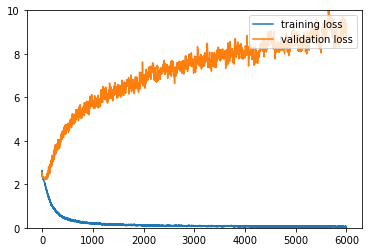

Epoch: 0000 loss_train: 2.3983 loss_val: 2.4053
Epoch: 0050 loss_train: 2.1344 loss_val: 2.2404
Epoch: 0100 loss_train: 1.8968 loss_val: 2.4020
Epoch: 0150 loss_train: 1.6234 loss_val: 2.6142
Epoch: 0200 loss_train: 1.4008 loss_val: 2.9994
Epoch: 0250 loss_train: 1.2249 loss_val: 3.3993
Epoch: 0300 loss_train: 1.1075 loss_val: 3.5862
Epoch: 0350 loss_train: 0.9829 loss_val: 3.8906
Epoch: 0400 loss_train: 0.8626 loss_val: 4.0961
Epoch: 0450 loss_train: 0.7706 loss_val: 4.3540
Epoch: 0500 loss_train: 0.7185 loss_val: 4.6130
Epoch: 0550 loss_train: 0.6734 loss_val: 4.5993
Epoch: 0600 loss_train: 0.6001 loss_val: 4.7749
Epoch: 0650 loss_train: 0.5541 loss_val: 4.9282
Epoch: 0700 loss_train: 0.5096 loss_val: 5.0489
Epoch: 0750 loss_train: 0.5030 loss_val: 5.2073
Epoch: 0800 loss_train: 0.4576 loss_val: 5.4627
Epoch: 0850 loss_train: 0.3978 loss_val: 5.5047
Epoch: 0900 loss_train: 0.4113 loss_val: 5.5780
Epoch: 0950 loss_train: 0.3876 loss_val: 5.6734
Epoch: 1000 loss_train: 0.3555 loss_val:

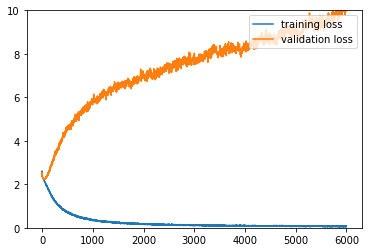

Epoch: 0000 loss_train: 2.3979 loss_val: 2.3851
Epoch: 0050 loss_train: 2.1603 loss_val: 2.3509
Epoch: 0100 loss_train: 1.8793 loss_val: 2.5874
Epoch: 0150 loss_train: 1.6059 loss_val: 2.9780
Epoch: 0200 loss_train: 1.3416 loss_val: 3.3271
Epoch: 0250 loss_train: 1.1660 loss_val: 3.7346
Epoch: 0300 loss_train: 0.9865 loss_val: 3.9036
Epoch: 0350 loss_train: 0.8890 loss_val: 4.4421
Epoch: 0400 loss_train: 0.7951 loss_val: 4.6894
Epoch: 0450 loss_train: 0.6605 loss_val: 4.8814
Epoch: 0500 loss_train: 0.6440 loss_val: 5.0070
Epoch: 0550 loss_train: 0.5890 loss_val: 5.2656
Epoch: 0600 loss_train: 0.5039 loss_val: 5.1877
Epoch: 0650 loss_train: 0.4672 loss_val: 5.4166
Epoch: 0700 loss_train: 0.4200 loss_val: 5.7991
Epoch: 0750 loss_train: 0.3974 loss_val: 5.7093
Epoch: 0800 loss_train: 0.4014 loss_val: 5.9429
Epoch: 0850 loss_train: 0.3577 loss_val: 5.8720
Epoch: 0900 loss_train: 0.3261 loss_val: 5.9542
Epoch: 0950 loss_train: 0.3218 loss_val: 6.0047
Epoch: 1000 loss_train: 0.2939 loss_val:

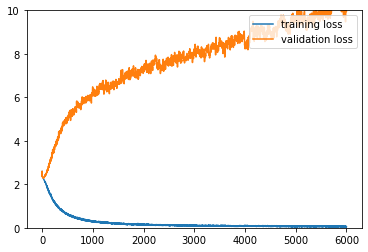

Epoch: 0000 loss_train: 2.3982 loss_val: 2.3910
Epoch: 0050 loss_train: 2.1547 loss_val: 2.2752
Epoch: 0100 loss_train: 1.8157 loss_val: 2.3897
Epoch: 0150 loss_train: 1.3985 loss_val: 2.6867
Epoch: 0200 loss_train: 1.1471 loss_val: 3.2423
Epoch: 0250 loss_train: 0.9829 loss_val: 3.5589
Epoch: 0300 loss_train: 0.8318 loss_val: 4.0653
Epoch: 0350 loss_train: 0.6565 loss_val: 4.3621
Epoch: 0400 loss_train: 0.5799 loss_val: 4.5545
Epoch: 0450 loss_train: 0.4960 loss_val: 5.0498
Epoch: 0500 loss_train: 0.4878 loss_val: 5.0712
Epoch: 0550 loss_train: 0.4552 loss_val: 5.5199
Epoch: 0600 loss_train: 0.4300 loss_val: 5.5485
Epoch: 0650 loss_train: 0.3805 loss_val: 5.9639
Epoch: 0700 loss_train: 0.3379 loss_val: 5.7177
Epoch: 0750 loss_train: 0.3085 loss_val: 5.9636
Epoch: 0800 loss_train: 0.2937 loss_val: 6.4422
Epoch: 0850 loss_train: 0.2905 loss_val: 6.3766
Epoch: 0900 loss_train: 0.2595 loss_val: 6.3862
Epoch: 0950 loss_train: 0.2500 loss_val: 6.5868
Epoch: 1000 loss_train: 0.2547 loss_val:

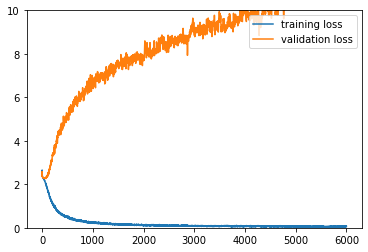

Epoch: 0000 loss_train: 2.3980 loss_val: 2.4121
Epoch: 0050 loss_train: 2.1741 loss_val: 2.4049
Epoch: 0100 loss_train: 1.8028 loss_val: 2.7801
Epoch: 0150 loss_train: 1.4000 loss_val: 3.5524
Epoch: 0200 loss_train: 1.1316 loss_val: 4.1552
Epoch: 0250 loss_train: 0.8810 loss_val: 4.6804
Epoch: 0300 loss_train: 0.7081 loss_val: 5.2694
Epoch: 0350 loss_train: 0.6427 loss_val: 5.4508
Epoch: 0400 loss_train: 0.5342 loss_val: 6.0236
Epoch: 0450 loss_train: 0.4896 loss_val: 6.1878
Epoch: 0500 loss_train: 0.4565 loss_val: 6.4796
Epoch: 0550 loss_train: 0.3858 loss_val: 6.6472
Epoch: 0600 loss_train: 0.3794 loss_val: 6.9248
Epoch: 0650 loss_train: 0.3180 loss_val: 6.7345
Epoch: 0700 loss_train: 0.3364 loss_val: 6.9910
Epoch: 0750 loss_train: 0.2859 loss_val: 7.2978
Epoch: 0800 loss_train: 0.2686 loss_val: 7.4607
Epoch: 0850 loss_train: 0.2298 loss_val: 7.2377
Epoch: 0900 loss_train: 0.2106 loss_val: 7.6070
Epoch: 0950 loss_train: 0.2155 loss_val: 7.5239
Epoch: 1000 loss_train: 0.2485 loss_val:

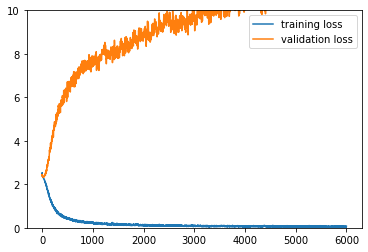

Epoch: 0000 loss_train: 2.3982 loss_val: 2.4121
Epoch: 0050 loss_train: 2.3084 loss_val: 2.3514
Epoch: 0100 loss_train: 2.1817 loss_val: 2.3883
Epoch: 0150 loss_train: 2.0253 loss_val: 2.4954
Epoch: 0200 loss_train: 1.8813 loss_val: 2.5893
Epoch: 0250 loss_train: 1.7094 loss_val: 2.7685
Epoch: 0300 loss_train: 1.5712 loss_val: 2.9237
Epoch: 0350 loss_train: 1.4611 loss_val: 3.0220
Epoch: 0400 loss_train: 1.3406 loss_val: 3.2749
Epoch: 0450 loss_train: 1.2608 loss_val: 3.3546
Epoch: 0500 loss_train: 1.1628 loss_val: 3.5511
Epoch: 0550 loss_train: 1.0994 loss_val: 3.7166
Epoch: 0600 loss_train: 1.0574 loss_val: 3.7462
Epoch: 0650 loss_train: 0.9852 loss_val: 3.8629
Epoch: 0700 loss_train: 0.9038 loss_val: 3.9510
Epoch: 0750 loss_train: 0.8768 loss_val: 4.2017
Epoch: 0800 loss_train: 0.8312 loss_val: 4.3319
Epoch: 0850 loss_train: 0.7917 loss_val: 4.4966
Epoch: 0900 loss_train: 0.7516 loss_val: 4.5235
Epoch: 0950 loss_train: 0.7039 loss_val: 4.5510
Epoch: 1000 loss_train: 0.6668 loss_val:

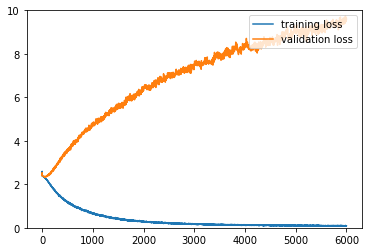

Epoch: 0000 loss_train: 2.3985 loss_val: 2.4240
Epoch: 0050 loss_train: 2.2705 loss_val: 2.2915
Epoch: 0100 loss_train: 2.1164 loss_val: 2.3616
Epoch: 0150 loss_train: 1.9169 loss_val: 2.4642
Epoch: 0200 loss_train: 1.7549 loss_val: 2.6071
Epoch: 0250 loss_train: 1.5837 loss_val: 2.7249
Epoch: 0300 loss_train: 1.4213 loss_val: 2.9552
Epoch: 0350 loss_train: 1.3053 loss_val: 3.1051
Epoch: 0400 loss_train: 1.1867 loss_val: 3.2782
Epoch: 0450 loss_train: 1.1078 loss_val: 3.3965
Epoch: 0500 loss_train: 1.0027 loss_val: 3.5154
Epoch: 0550 loss_train: 0.9449 loss_val: 3.6263
Epoch: 0600 loss_train: 0.8732 loss_val: 3.7835
Epoch: 0650 loss_train: 0.8077 loss_val: 3.9603
Epoch: 0700 loss_train: 0.7584 loss_val: 4.0442
Epoch: 0750 loss_train: 0.7122 loss_val: 4.0597
Epoch: 0800 loss_train: 0.6826 loss_val: 4.1197
Epoch: 0850 loss_train: 0.6398 loss_val: 4.3184
Epoch: 0900 loss_train: 0.5868 loss_val: 4.4050
Epoch: 0950 loss_train: 0.5770 loss_val: 4.3524
Epoch: 1000 loss_train: 0.5136 loss_val:

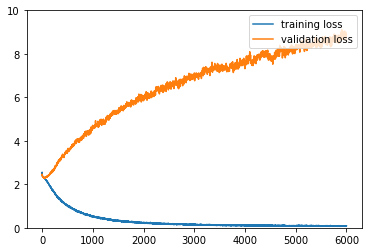

Epoch: 0000 loss_train: 2.4178 loss_val: 2.5087
Epoch: 0050 loss_train: 2.2743 loss_val: 2.3272
Epoch: 0100 loss_train: 2.1488 loss_val: 2.3725
Epoch: 0150 loss_train: 1.9995 loss_val: 2.4300
Epoch: 0200 loss_train: 1.8664 loss_val: 2.5268
Epoch: 0250 loss_train: 1.7072 loss_val: 2.6087
Epoch: 0300 loss_train: 1.5902 loss_val: 2.7183
Epoch: 0350 loss_train: 1.4684 loss_val: 2.9246
Epoch: 0400 loss_train: 1.3378 loss_val: 2.9969
Epoch: 0450 loss_train: 1.2097 loss_val: 3.1666
Epoch: 0500 loss_train: 1.0859 loss_val: 3.3675
Epoch: 0550 loss_train: 0.9901 loss_val: 3.4949
Epoch: 0600 loss_train: 0.9048 loss_val: 3.5808
Epoch: 0650 loss_train: 0.8128 loss_val: 3.7623
Epoch: 0700 loss_train: 0.7541 loss_val: 3.9814
Epoch: 0750 loss_train: 0.6796 loss_val: 4.0639
Epoch: 0800 loss_train: 0.6302 loss_val: 4.2276
Epoch: 0850 loss_train: 0.5802 loss_val: 4.3954
Epoch: 0900 loss_train: 0.5462 loss_val: 4.6430
Epoch: 0950 loss_train: 0.5107 loss_val: 4.5878
Epoch: 1000 loss_train: 0.4894 loss_val:

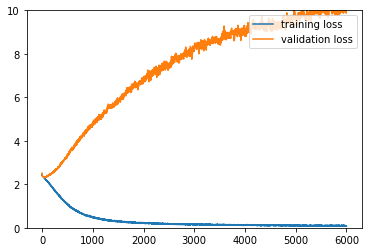

Epoch: 0000 loss_train: 2.4180 loss_val: 2.4883
Epoch: 0050 loss_train: 2.1909 loss_val: 2.3928
Epoch: 0100 loss_train: 2.0035 loss_val: 2.5043
Epoch: 0150 loss_train: 1.8424 loss_val: 2.6202
Epoch: 0200 loss_train: 1.6178 loss_val: 2.7327
Epoch: 0250 loss_train: 1.4567 loss_val: 2.8384
Epoch: 0300 loss_train: 1.2950 loss_val: 3.0103
Epoch: 0350 loss_train: 1.1509 loss_val: 3.2015
Epoch: 0400 loss_train: 1.0377 loss_val: 3.4258
Epoch: 0450 loss_train: 0.9497 loss_val: 3.5364
Epoch: 0500 loss_train: 0.8305 loss_val: 3.8675
Epoch: 0550 loss_train: 0.7470 loss_val: 3.9324
Epoch: 0600 loss_train: 0.6907 loss_val: 4.2072
Epoch: 0650 loss_train: 0.6437 loss_val: 4.3365
Epoch: 0700 loss_train: 0.5947 loss_val: 4.6253
Epoch: 0750 loss_train: 0.5514 loss_val: 4.6820
Epoch: 0800 loss_train: 0.4913 loss_val: 4.8614
Epoch: 0850 loss_train: 0.4832 loss_val: 4.9928
Epoch: 0900 loss_train: 0.4369 loss_val: 5.2482
Epoch: 0950 loss_train: 0.3843 loss_val: 5.3707
Epoch: 1000 loss_train: 0.3895 loss_val:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 1400 loss_train: 0.2688 loss_val: 5.5906
Epoch: 1450 loss_train: 0.2597 loss_val: 5.6058
Epoch: 1500 loss_train: 0.2370 loss_val: 5.7233
Epoch: 1550 loss_train: 0.2445 loss_val: 5.7569
Epoch: 1600 loss_train: 0.2499 loss_val: 5.9478
Epoch: 1650 loss_train: 0.2317 loss_val: 6.0569
Epoch: 1700 loss_train: 0.2348 loss_val: 5.8709
Epoch: 1750 loss_train: 0.2179 loss_val: 5.9979
Epoch: 1800 loss_train: 0.2014 loss_val: 6.1636
Epoch: 1850 loss_train: 0.2162 loss_val: 6.3274
Epoch: 1900 loss_train: 0.1981 loss_val: 6.4533
Epoch: 1950 loss_train: 0.2079 loss_val: 6.5076
Epoch: 2000 loss_train: 0.2066 loss_val: 6.3608
Epoch: 2050 loss_train: 0.2012 loss_val: 6.6162
Epoch: 2100 loss_train: 0.1891 loss_val: 6.7753
Epoch: 2150 loss_train: 0.1914 loss_val: 6.6316
Epoch: 2200 loss_train: 0.1836 loss_val: 6.8701
Epoch: 2250 loss_train: 0.2009 loss_val: 6.8005
Epoch: 2300 loss_train: 0.1791 loss_val: 6.8675
Epoch: 2350 loss_train: 0.1705 loss_val: 7.1131
Epoch: 2400 loss_train: 0.1680 loss_val:

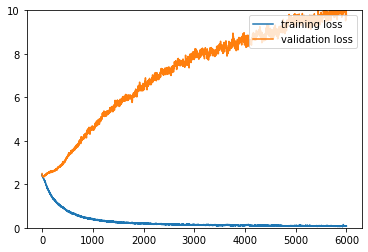

Epoch: 0000 loss_train: 2.3989 loss_val: 2.3935
Epoch: 0050 loss_train: 2.2710 loss_val: 2.3526
Epoch: 0100 loss_train: 2.1087 loss_val: 2.4186
Epoch: 0150 loss_train: 1.9060 loss_val: 2.5712
Epoch: 0200 loss_train: 1.6702 loss_val: 2.8525
Epoch: 0250 loss_train: 1.5127 loss_val: 3.0054
Epoch: 0300 loss_train: 1.3332 loss_val: 3.2905
Epoch: 0350 loss_train: 1.2088 loss_val: 3.5081
Epoch: 0400 loss_train: 1.1042 loss_val: 3.7276
Epoch: 0450 loss_train: 1.0161 loss_val: 3.8686
Epoch: 0500 loss_train: 0.9544 loss_val: 3.9076
Epoch: 0550 loss_train: 0.8909 loss_val: 4.0887
Epoch: 0600 loss_train: 0.8096 loss_val: 4.2697
Epoch: 0650 loss_train: 0.7829 loss_val: 4.2016
Epoch: 0700 loss_train: 0.7015 loss_val: 4.4500
Epoch: 0750 loss_train: 0.6689 loss_val: 4.3412
Epoch: 0800 loss_train: 0.6310 loss_val: 4.5392
Epoch: 0850 loss_train: 0.5960 loss_val: 4.7097
Epoch: 0900 loss_train: 0.5287 loss_val: 4.9246
Epoch: 0950 loss_train: 0.5121 loss_val: 4.9447
Epoch: 1000 loss_train: 0.4942 loss_val:

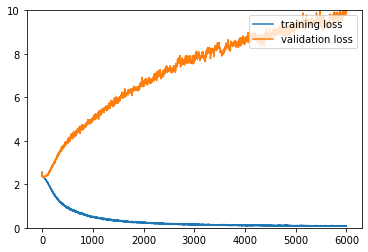

In [19]:
pctVal=0.05
pctTest=0.1

for i in np.unique(clusterRes):
    logsavepath_i=os.path.join(logsavepath,str(i))
    plotsavepath_i=os.path.join(plotsavepath,str(i))
    modelsavepath_i=os.path.join(modelsavepath,str(i))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(clusterRes_sub[clusterRes==i]):
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=latent[plottingIdx_i.astype(int)][np.logical_and(clusterRes==i,clusterRes_sub==i_sub)]
        labels_sub_str=progList[plottingIdx_i.astype(int)][np.logical_and(clusterRes==i,clusterRes_sub==i_sub)]
        labelnames,labels_sub=np.unique(labels_sub_str,return_inverse=True)
        with open(os.path.join(plotsavepath_sub,'labelnames'), 'wb') as output:
            pickle.dump(labelnames, output, pickle.HIGHEST_PROTOCOL)
        
        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        fig, ax = plt.subplots()
        plt.bar(trainLabels,traincounts)
        plt.xticks(np.arange(trainLabels.size),labelnames[trainLabels])
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        plt.tight_layout()
        plt.savefig(os.path.join(plotsavepath_sub,'labelCounts.jpg'))
        plt.close()

        weightClf=np.zeros(traincounts.size)
        for w in range(traincounts.size):
            weightClf[w]=np.sum(traincounts)/traincounts[w]/10
            
        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_sub).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

        for ep in range(epochs):
        # for ep in range(10000,20000):

            train_loss_ep[ep],val_loss_ep[ep]=train(ep)


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_sub,str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))
        with open(os.path.join(logsavepath_sub,'train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_sub,'val_loss'), 'wb') as output:
            pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        plt.plot(np.arange(epochs),train_loss_ep)
        plt.plot(np.arange(epochs),val_loss_ep)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.ylim(0,10)
        plt.savefig(os.path.join(plotsavepath_sub,'loss_seed3.jpg'))
        plt.show()



In [20]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',labelnames=None):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(np.unique(labels).size))
    if labelnames is None:
        ax.set_yticklabels(np.unique(labels))
    else:
        ax.set_yticklabels(labelnames[np.unique(labels)])
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    if labelnames is None:
        ax.set_xticklabels(np.unique(ctlist))
    else:
        ax.set_xticklabels(labelnames[np.unique(labels)])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [9]:
#plot confusion
ctorder=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Invasive ductal carcinoma (breast tissue)','Hyperplasia','Atypical hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=ctorder):
    res=np.zeros((order.size,order.size))
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    

In [10]:
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList[progList==p]='DCIS'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList[progList==p]='DCIS with early infiltration'
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList[progList==p]='Micropapillary DCIS with early infiltration'


In [18]:
#test loss
ep=5800
pctVal=0.05
pctTest=0.1
for c in np.unique(clusterRes):
    print(c)
    logsavepath_i=os.path.join(logsavepath,str(c))
    plotsavepath_i=os.path.join(plotsavepath,str(c))
    modelsavepath_i=os.path.join(modelsavepath,str(c))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(clusterRes_sub[clusterRes==c]):
        print(i_sub)
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=latent[plottingIdx_i.astype(int)][np.logical_and(clusterRes==c,clusterRes_sub==i_sub)]
        labels_sub_str=progList[plottingIdx_i.astype(int)][np.logical_and(clusterRes==c,clusterRes_sub==i_sub)]
        labelnames,labels_sub=np.unique(labels_sub_str,return_inverse=True)

    
        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        
        weightClf=np.zeros(traincounts.size)
        for i in range(traincounts.size):
            weightClf[i]=np.sum(traincounts)/traincounts[i]/10
            
        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_sub).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weightClf).cuda().float())

        if use_cuda:
            model.cuda()

        model.load_state_dict(torch.load(os.path.join(modelsavepath_sub,str(ep)+'.pt')))
        predtest=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_test_all=0
            ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
            for i in range(ntestBatches):
                testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
                testInput=torch.tensor(stats_sub[testIdx_i])
                if use_cuda:
                    testInput=testInput.cuda().float()
                    labels=torch.tensor(labels_sub[testIdx_i]).cuda().long()
                pred = model(testInput)
                predtest=np.concatenate((predtest,np.argmax(pred.cpu().detach().numpy(),axis=1)))

                loss_test=lossCE(pred,labels).item()

                loss_test_all+=loss_test

            loss_test_all=loss_test_all/ntestBatches

        print('test loss: '+str(loss_test_all))

#         plotCTcomp(labels_sub[testIdx],predtest,plotsavepath_sub,'confusion_test',False,labelnames=labelnames)
        plotCTcomp(labelnames[labels_sub[testIdx]],labelnames[predtest.astype(int)],plotsavepath_sub,'confusion_test',False)


        predtrain=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_train_all=0
            ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
            for i in range(ntrainBatches):
                trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
                trainInput=torch.tensor(stats_sub[trainIdx_i])
                if use_cuda:
                    trainInput=trainInput.cuda().float()
                    labels=torch.tensor(labels_sub[trainIdx_i]).cuda().long()
                pred = model(trainInput)
                predtrain=np.concatenate((predtrain,np.argmax(pred.cpu().detach().numpy(),axis=1)))

                loss_train=lossCE(pred,labels).item()

                loss_train_all+=loss_train

            loss_train_all=loss_train_all/ntrainBatches

        print('train loss: '+str(loss_train_all))
#         plotCTcomp(labels_sub[trainIdx],predtrain,plotsavepath_sub,'confusion_train',False,labelnames=labelnames)
        plotCTcomp(labelnames[labels_sub[trainIdx]],labelnames[predtrain.astype(int)],plotsavepath_sub,'confusion_train',False)

0
0.0
test loss: 10.030037879943848
train loss: 3.035507324966602e-05
1.0
test loss: 8.824554443359375
train loss: 3.528062370605767e-05
2.0
test loss: 9.30605697631836
train loss: 3.3704993256833404e-05
3.0
test loss: 9.970162391662598
train loss: 3.9913248883749475e-05
1
0.0
test loss: 11.761611938476562
train loss: 2.215962115315051e-05
1.0
test loss: 11.634525299072266
train loss: 0.0002986147335377609
2.0
test loss: 11.586739540100098
train loss: 5.857033465872519e-05
3.0
test loss: 12.440653800964355
train loss: 5.487079397425987e-05
4.0
test loss: 9.994588851928711
train loss: 1.7465979528008546e-05
5.0
test loss: 12.285201072692871
train loss: 5.508468530024402e-05
2
0.0
test loss: 10.194725036621094
train loss: 4.7170804464258254e-05
1.0
test loss: 9.168804168701172
train loss: 2.3112783310352825e-05
2.0
test loss: 9.455323219299316
train loss: 1.730551230139099e-05
3.0
test loss: 7.9070634841918945
train loss: 5.2428713388508186e-05
4.0
test loss: 10.048834800720215
train los

In [41]:
np.sum(np.logical_and(alllabels==i,alllabels_sub==i_sub))

0

In [17]:
predtest

array([ 4.,  7., 10.,  4.,  7., 10.,  5.,  0.,  2.,  5.,  7.,  1.,  4.,
        2.,  7.,  2.,  7.,  2.,  2.,  2.,  7.,  0.,  4.,  8.,  9.,  3.,
        5.,  2., 10.,  5.,  3.,  3.,  1.,  5.,  5.,  1., 10.,  5.,  6.,
        5.,  5., 10., 10.,  2.,  0.,  7.,  3.,  3.,  8.,  6.,  2.,  3.,
        0., 10.,  3.,  4.,  4.,  6.,  3.,  2.,  1.,  6.,  1.,  5.,  9.,
        4.,  2.,  5., 10., 10.,  8.,  5.,  6.,  8.,  4.,  5.,  7.,  5.,
        4.,  0.,  6.,  3., 10., 10., 10.,  0., 10.,  2.,  7.,  2.,  4.,
        6.,  0.,  7.,  5.,  4.,  7.,  7.,  4.,  6.,  9.,  5.,  7.,  8.,
        2.,  3., 10.,  5., 10.,  7.,  8., 10.,  8.,  4., 10.,  7., 10.,
        0.,  5., 10.,  6.,  0.,  9.,  7.,  2.,  7.,  3.,  5., 10., 10.,
        0.,  2.,  9.,  4.,  0.,  5.,  5.,  9.,  4.,  4.,  9.,  1.,  5.,
        5.,  2.,  5.,  6.,  6.,  3.,  2.,  0.,  0.,  3.,  4.,  7.,  9.,
        9.,  4.,  7.,  4.,  4., 10.,  9., 10.,  2.,  2.,  7.,  0.,  8.,
        0.,  5.,  4.,  1.,  5.,  3.,  7.,  9.,  3., 10., 10.,  0

In [43]:
i_sub

4.0

In [44]:
np.unique(alllabels_sub[alllabels==i])

array([0., 1., 2., 3.])